In [ ]:
# Imports
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from datetime import datetime

In [ ]:
# DefIne start and end dates for the data
end = datetime.now()
start = datetime(end.year - 4, end.month, end.day)

In [ ]:
# Define companies and download data
companies = ['HDB', 'ITCI', 'ONGC.NS', 'TATASTEEL.NS', 'BRITANNIA.NS', 'RELIANCE.NS', 'DIVISLAB.NS', 'BAJFINANCE.NS', 'SBIN.NS', 'ASIANPAINT.NS']
data = {}
for company in companies:
    data[company] = yf.download(company, start=start, end=end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


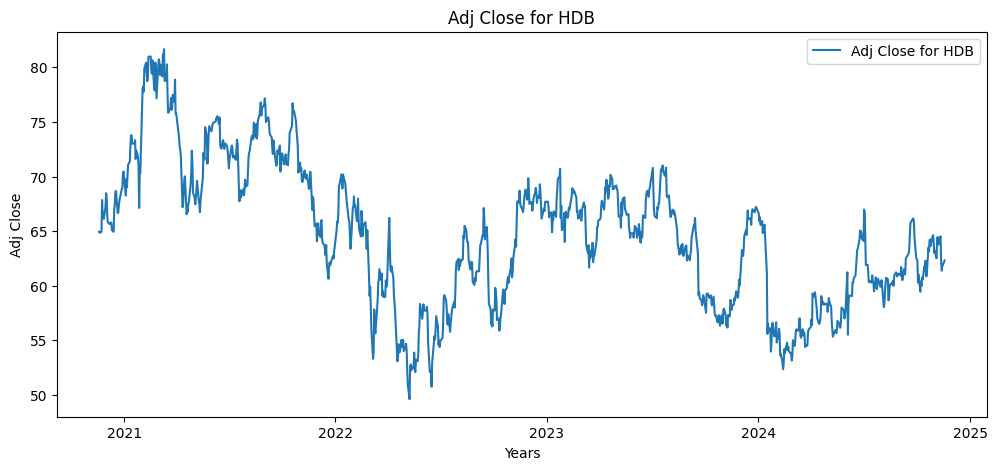

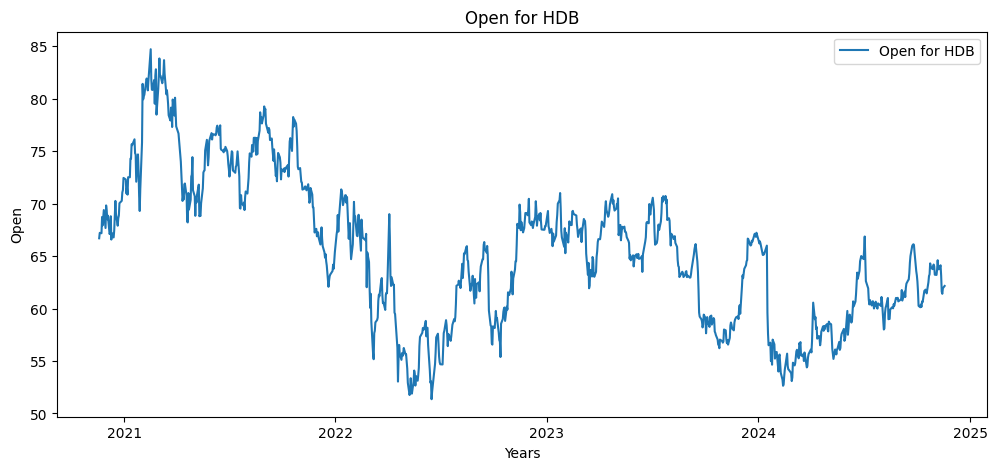

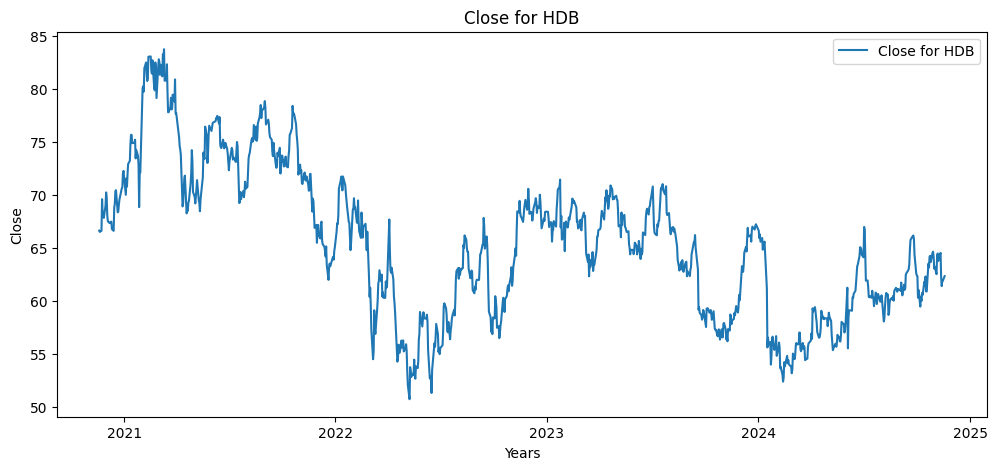

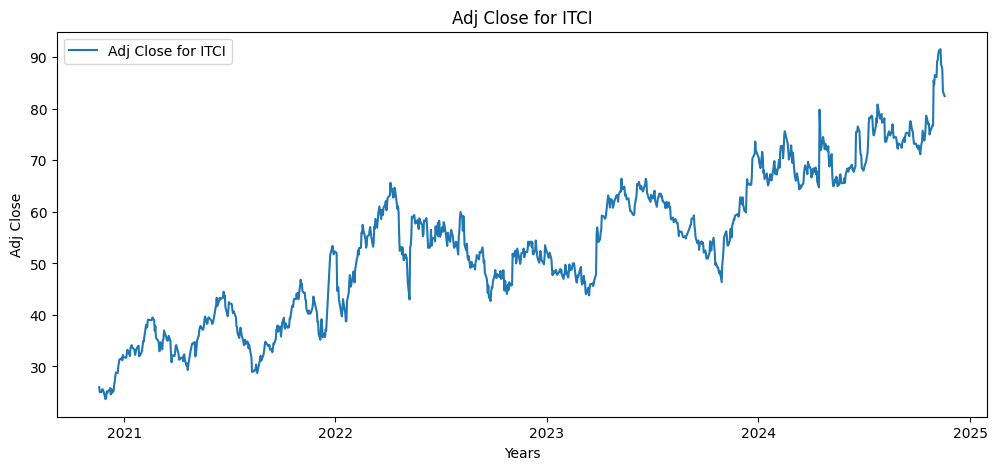

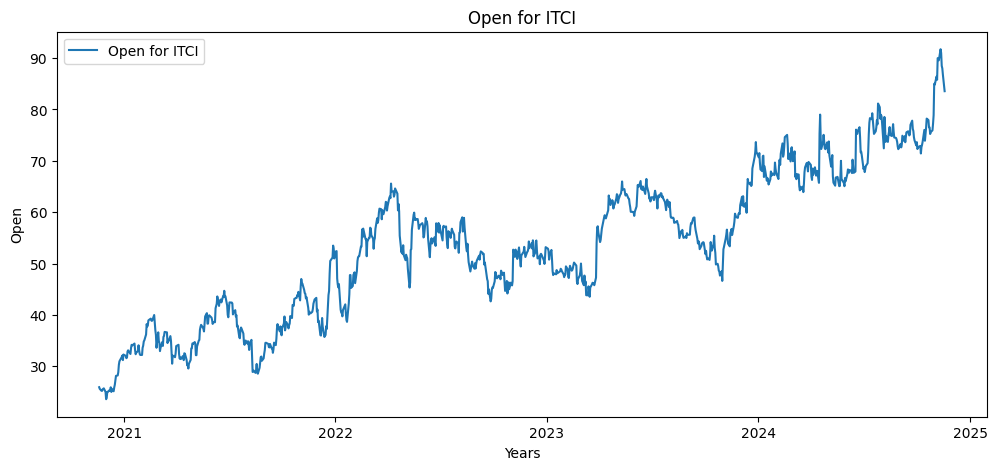

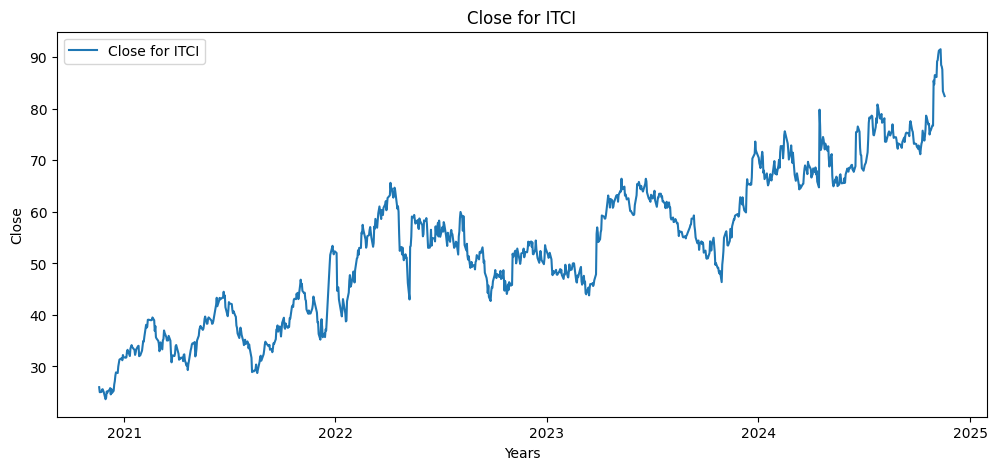

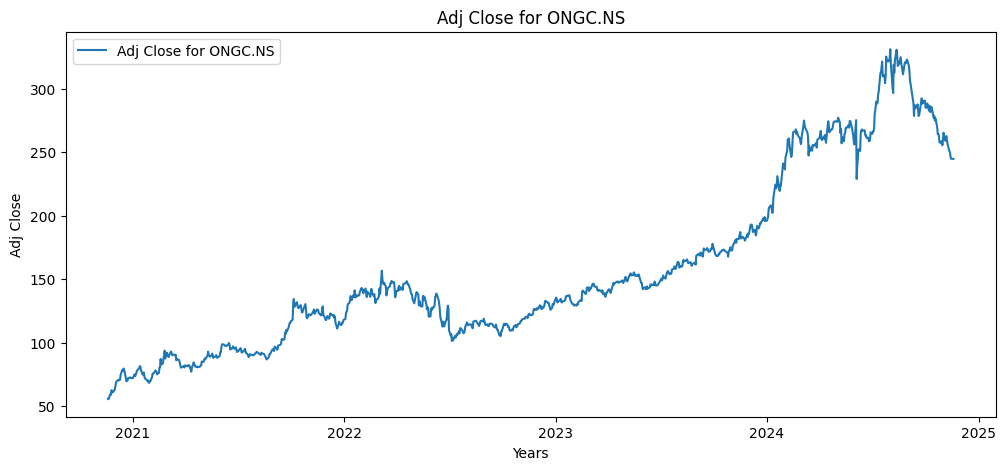

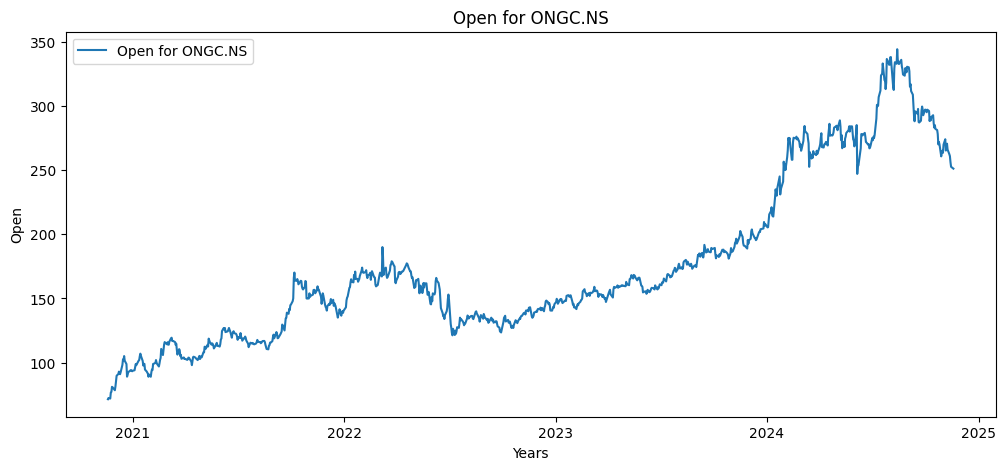

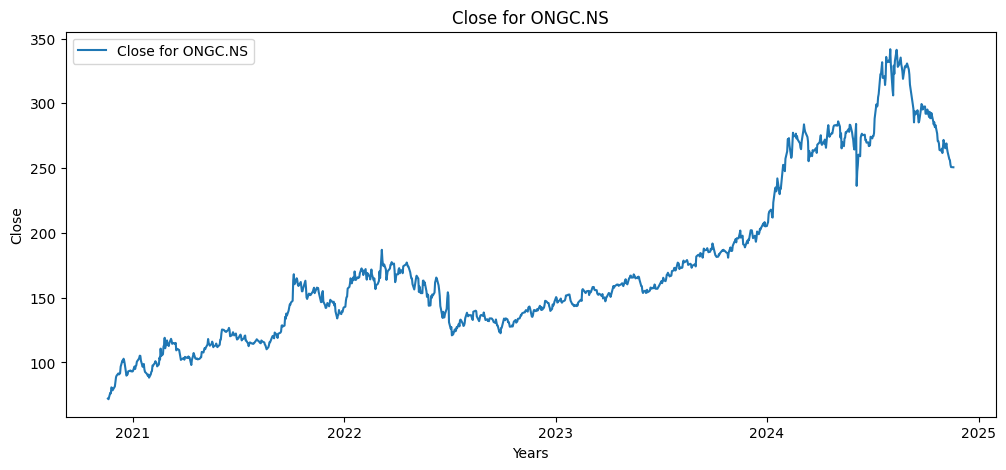

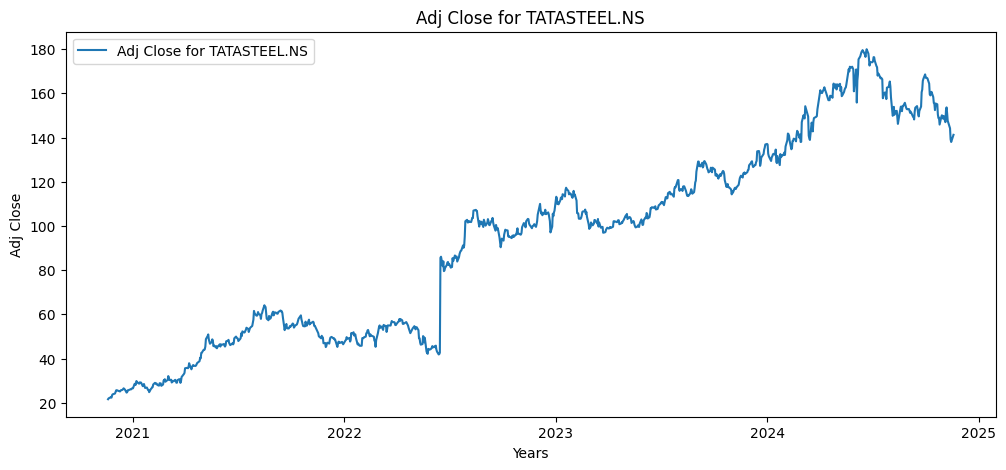

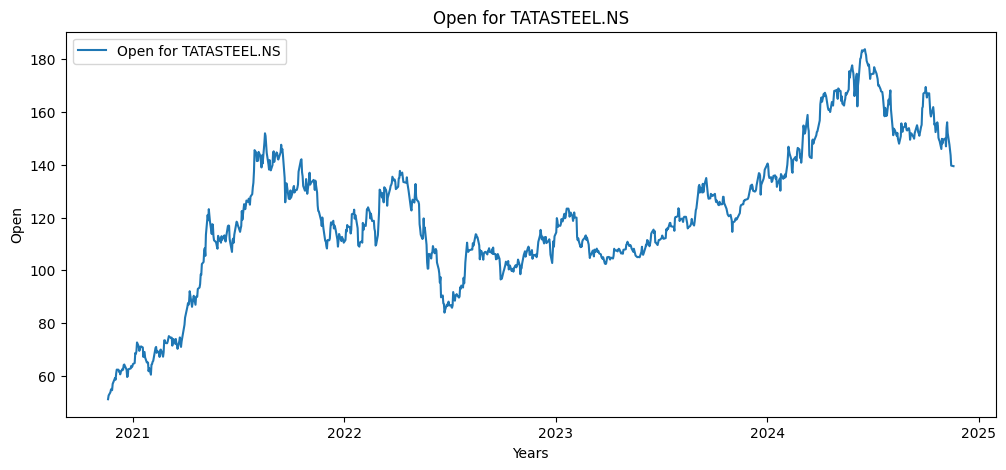

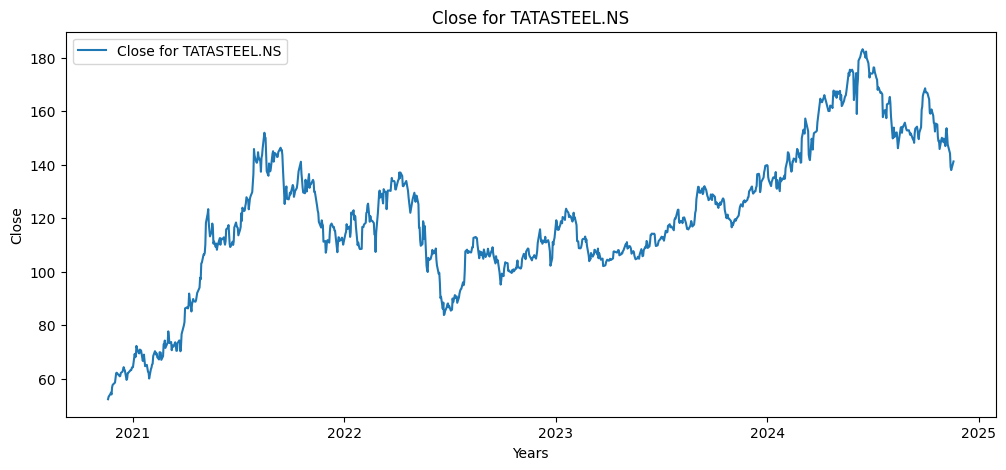

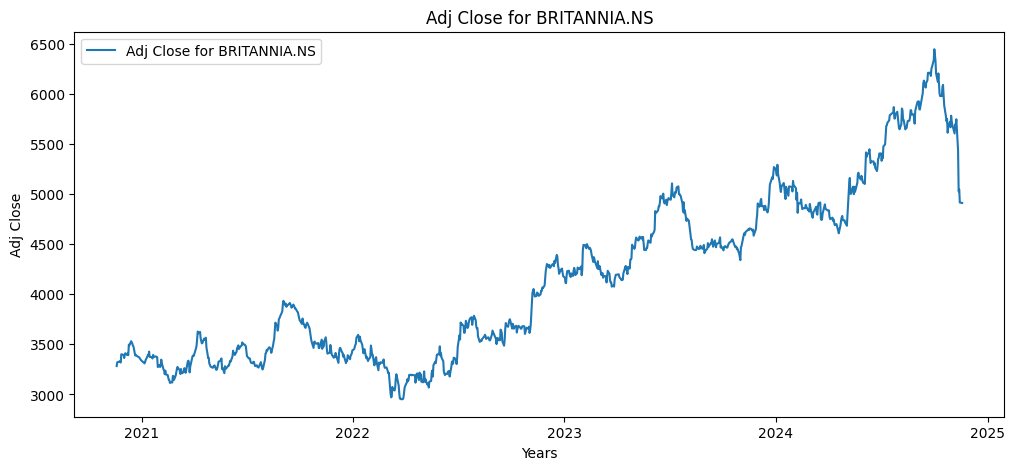

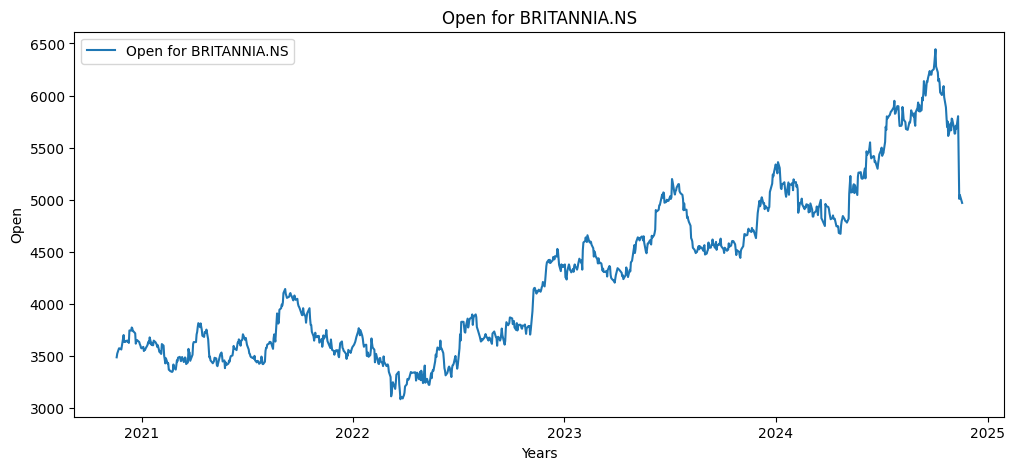

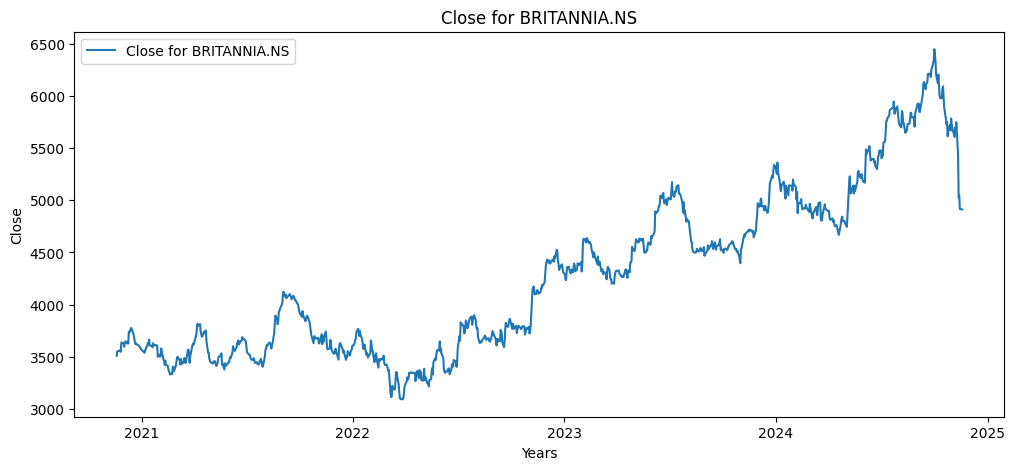

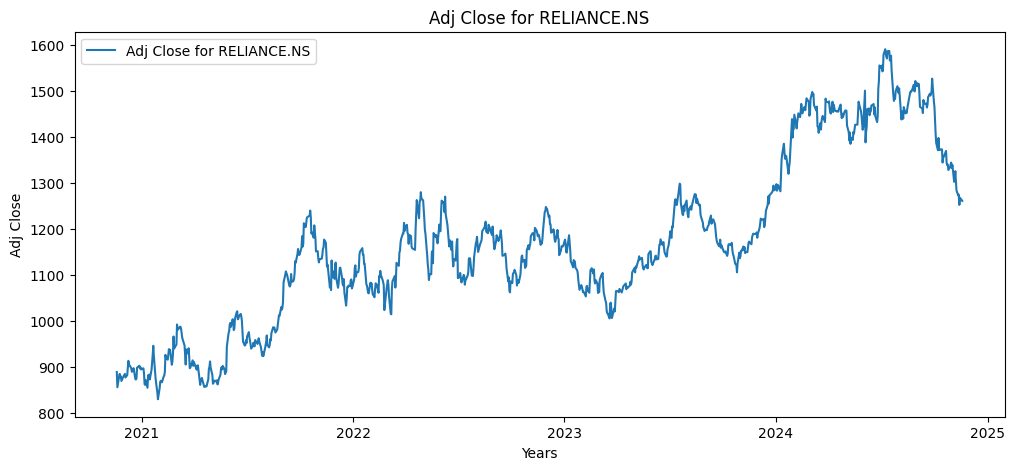

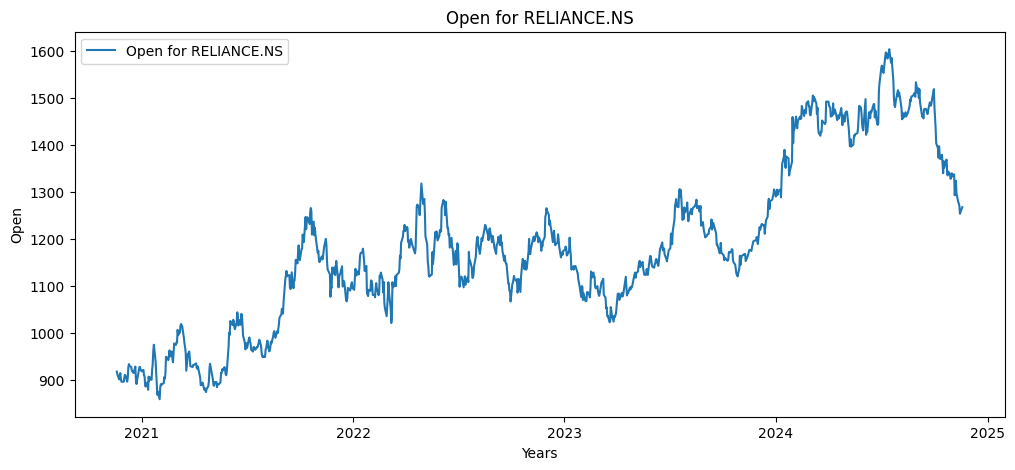

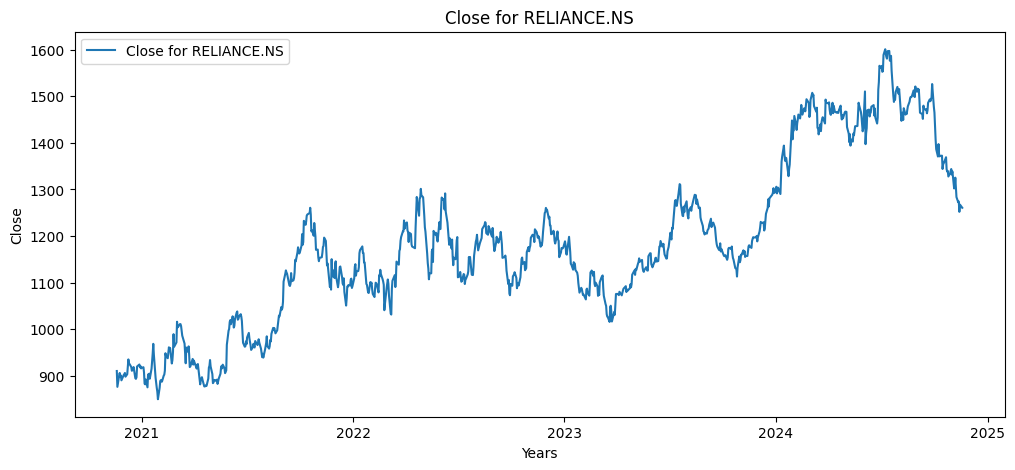

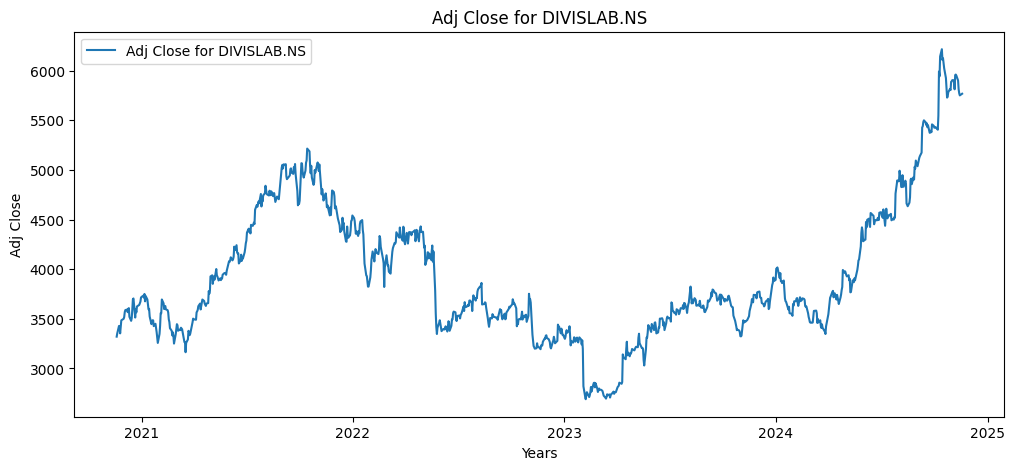

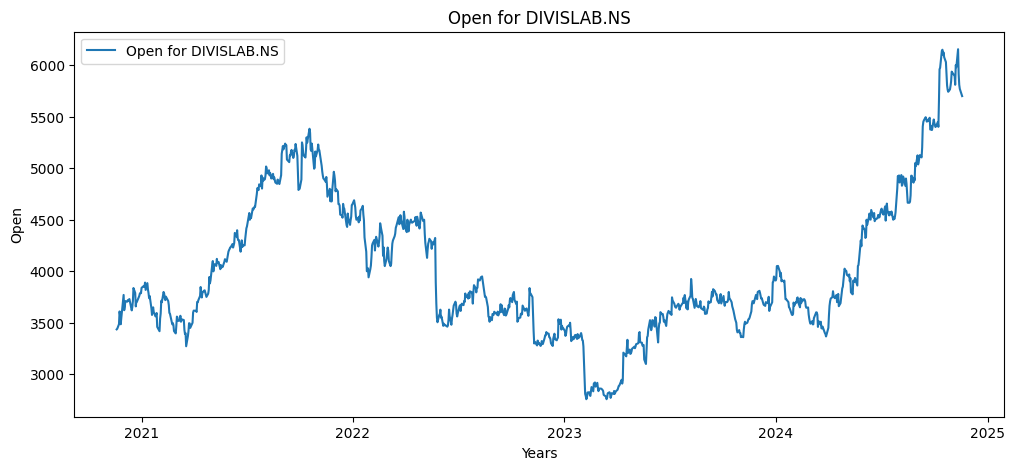

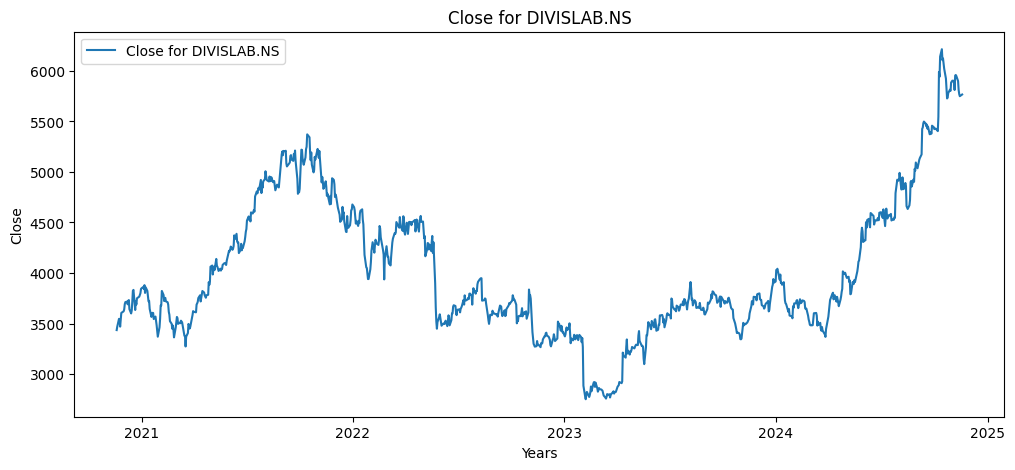

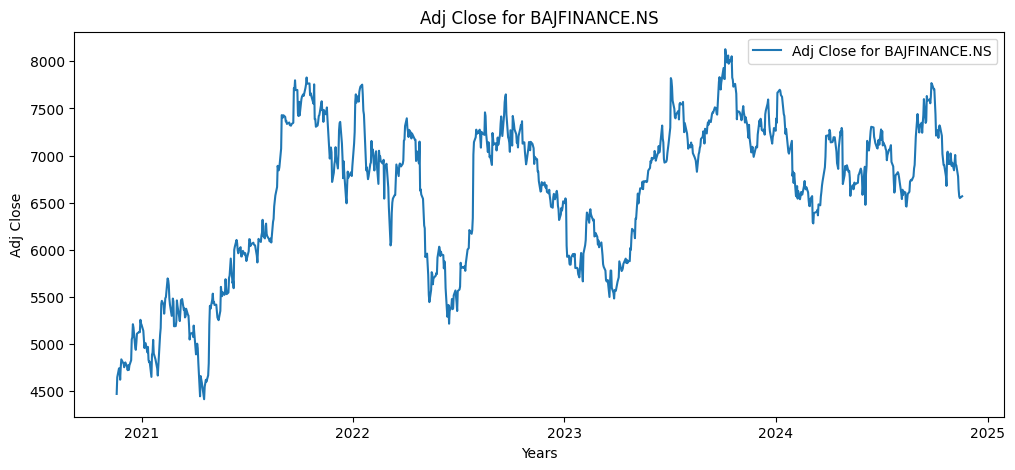

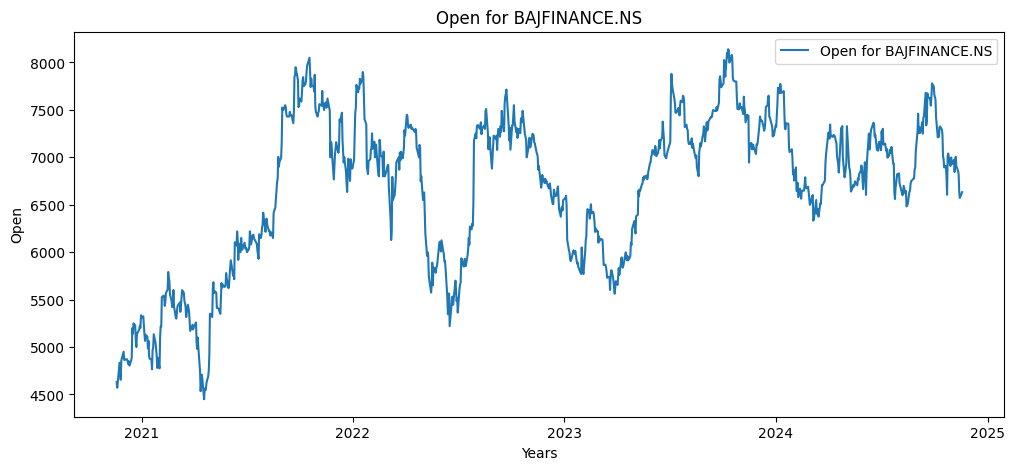

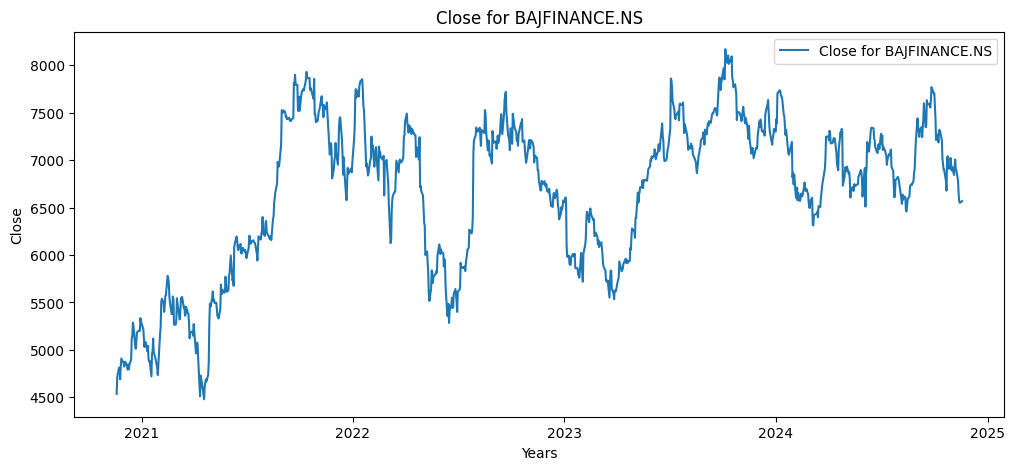

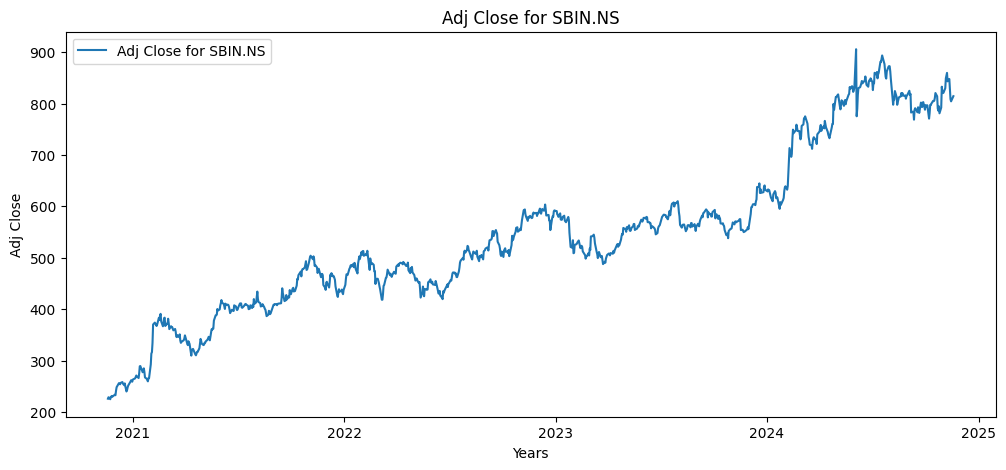

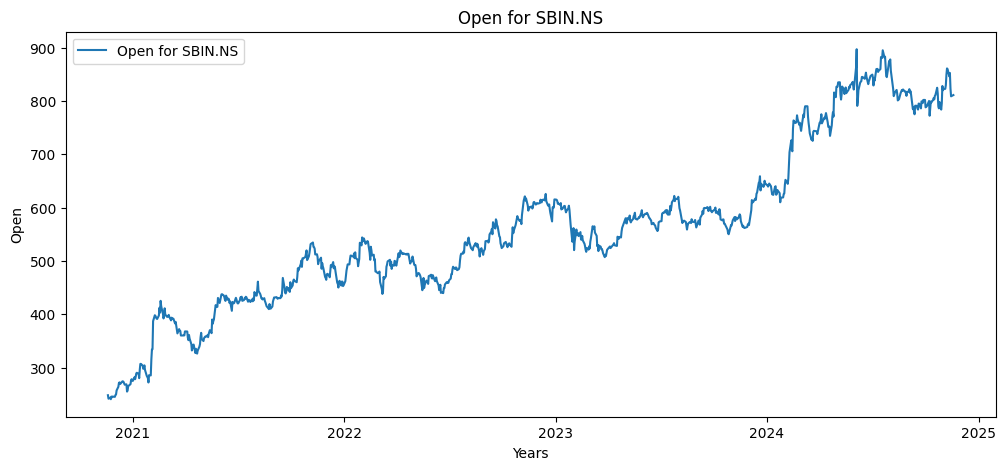

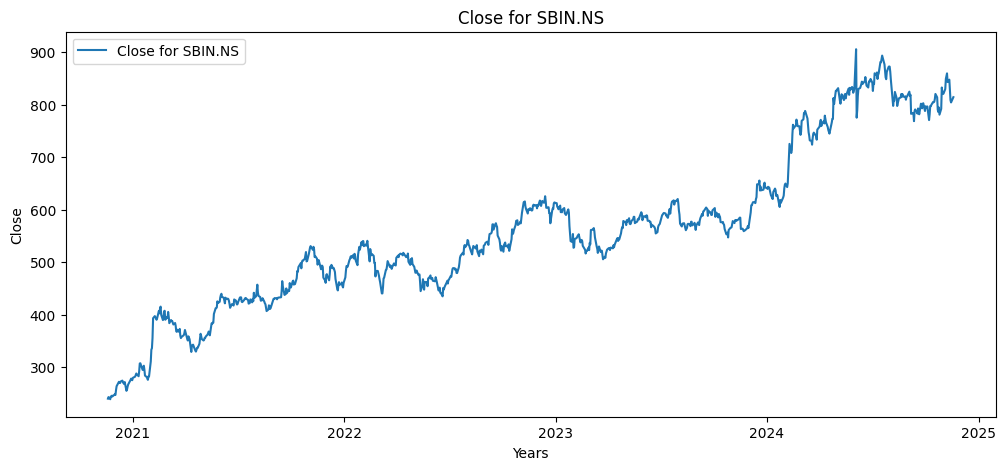

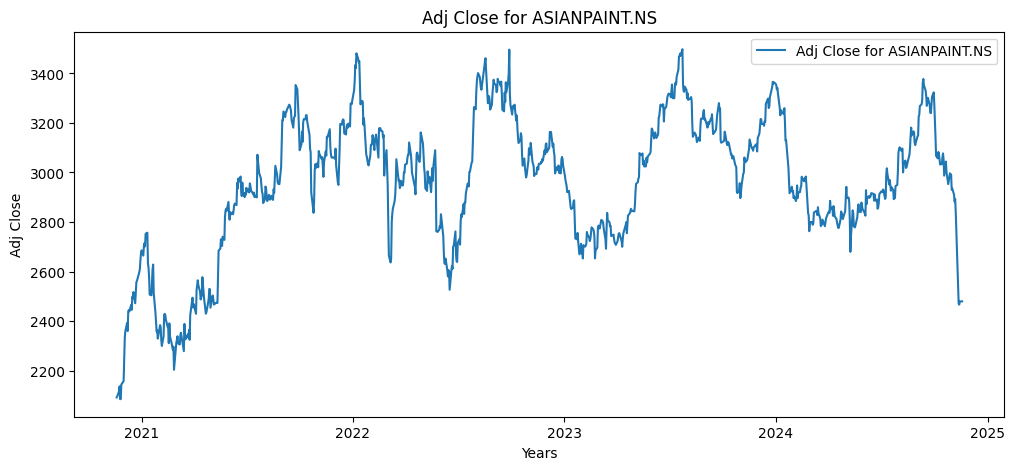

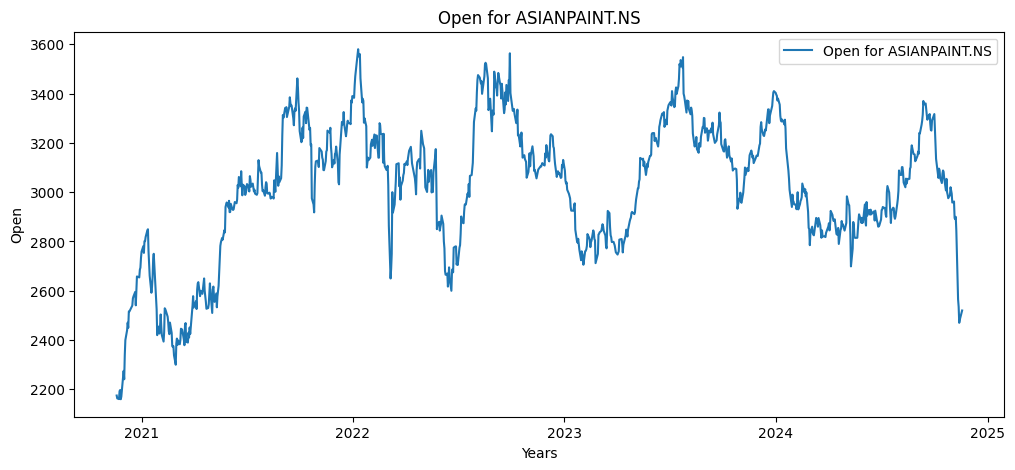

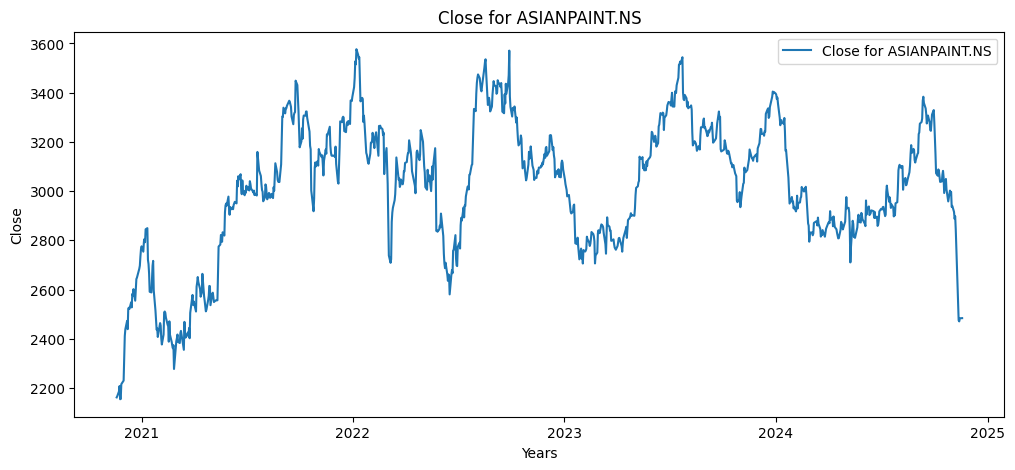

In [ ]:
# Plot Adjusted Closing Price, Open Price, and Close Price for each company
for company in companies:
    for column in ['Adj Close', 'Open', 'Close']:
        fig, ax = plt.subplots(figsize=(12, 5))
        ax.plot(data[company][column], label=f"{column} for {company}")
        ax.set_title(f'{column} for {company}')
        ax.set_xlabel('Years')
        ax.set_ylabel(column)
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.legend()
        plt.show()

In [ ]:
# Data processing and model setup
df = data['HDB'][['Close']].dropna()  # Use 'Close' price

In [ ]:
# Data Preprocessing: Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

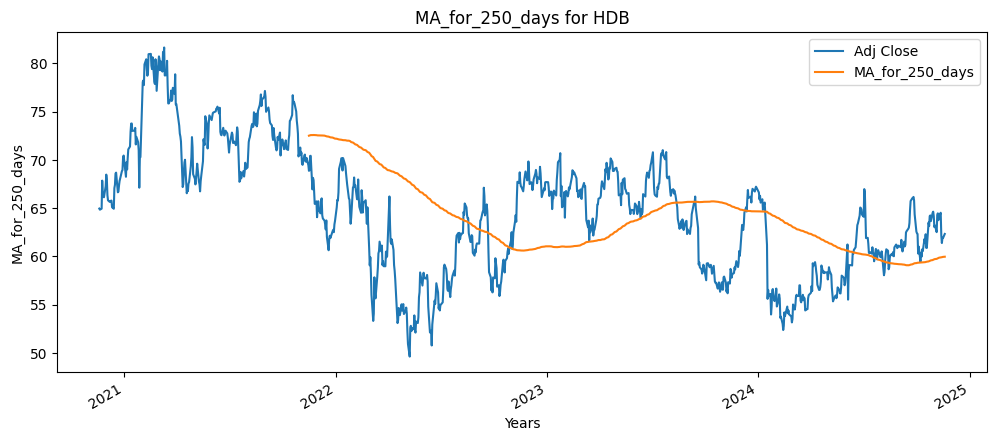

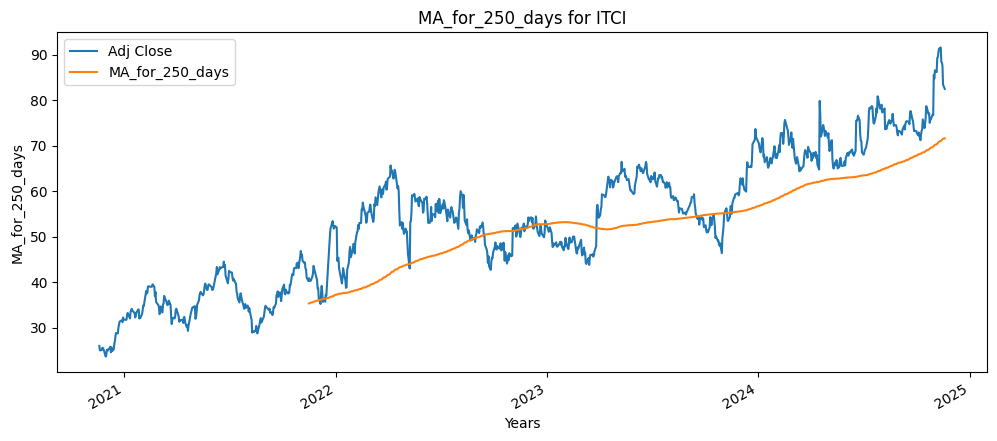

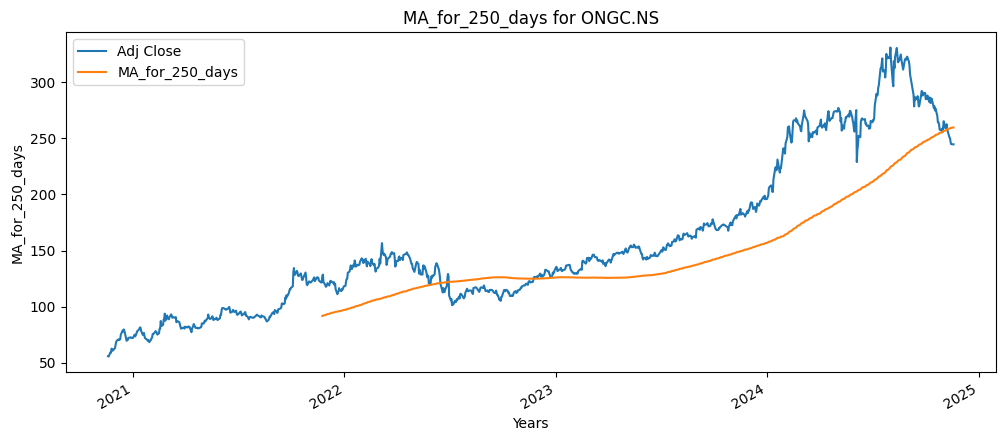

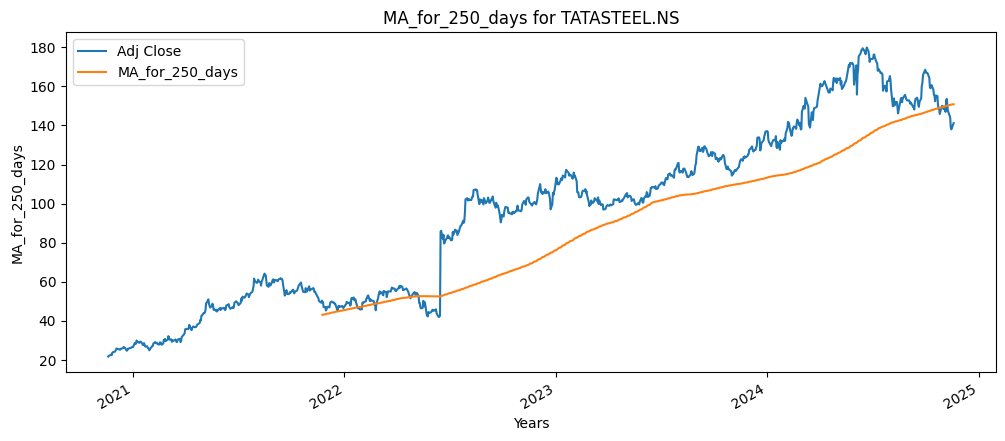

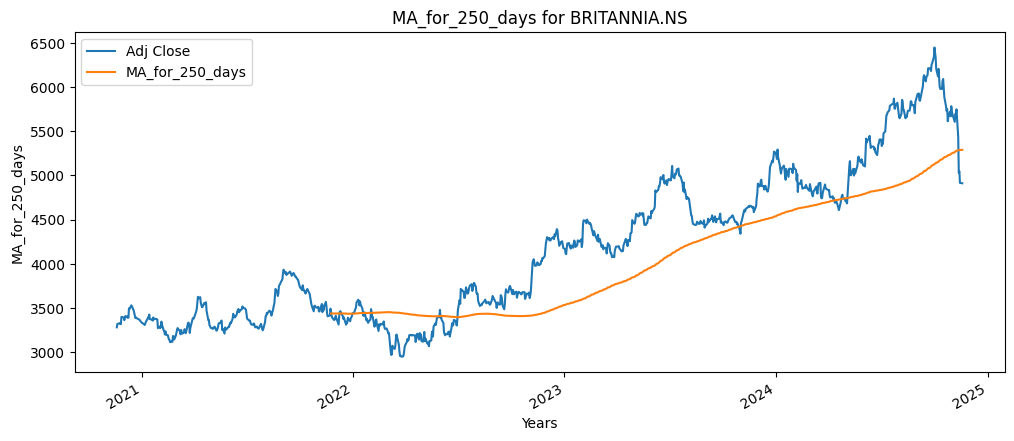

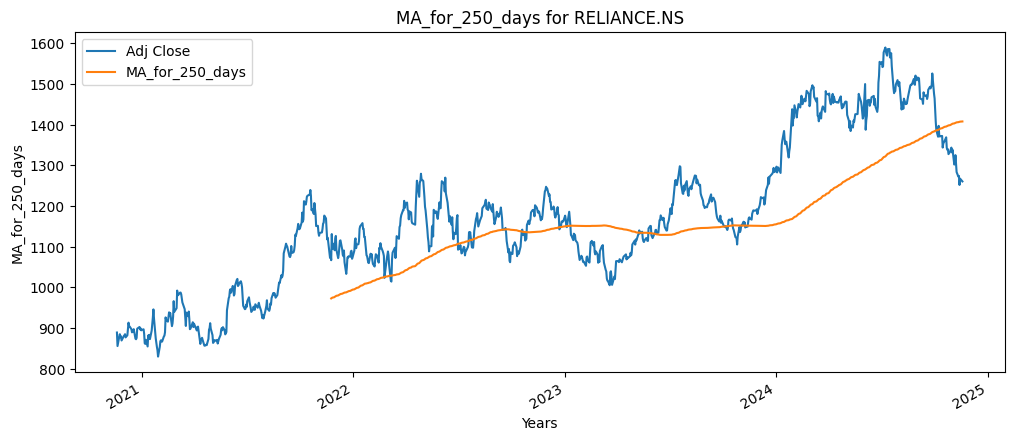

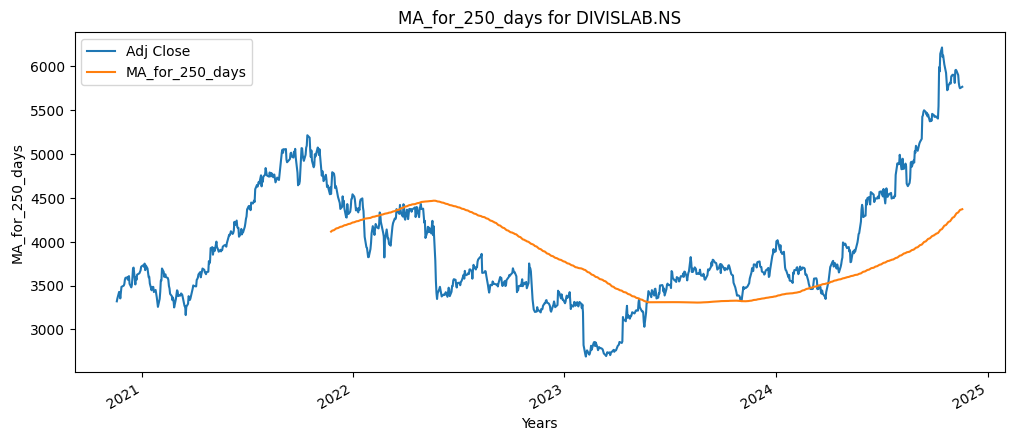

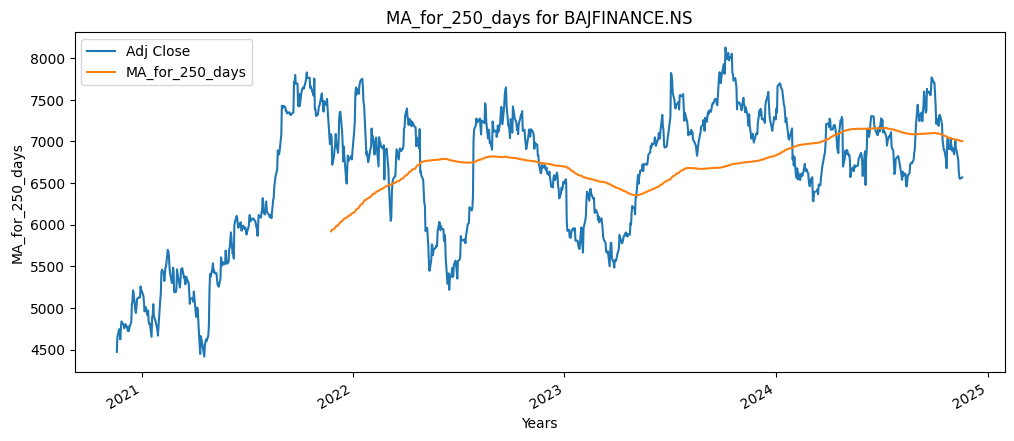

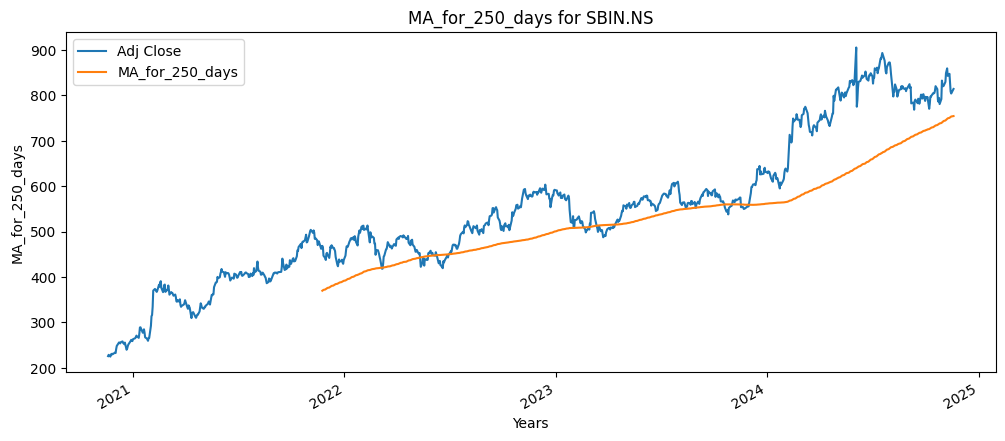

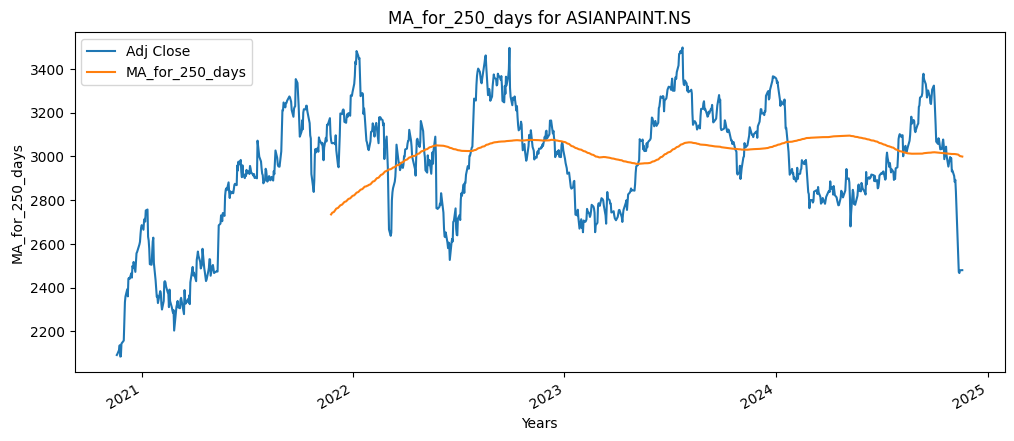

In [ ]:
for company in companies:
  data[company]['MA_for_250_days']=data[company]['Adj Close'].rolling(250).mean()
  fig, ax=plt.subplots(figsize =(12,5))
  ax.plot(data[company]['Adj Close'], label='Adj Close')
  ax.plot(data[company]['MA_for_250_days'], label='MA_for_250_days')
  ax.set_title(f'MA_for_250_days for {company}')
  ax.set_xlabel('Years')
  ax.set_ylabel('MA_for_250_days')
  ax.xaxis.set_major_locator(mdates.YearLocator())
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

  plt.gcf().autofmt_xdate()
  ax.legend()
  plt.show()

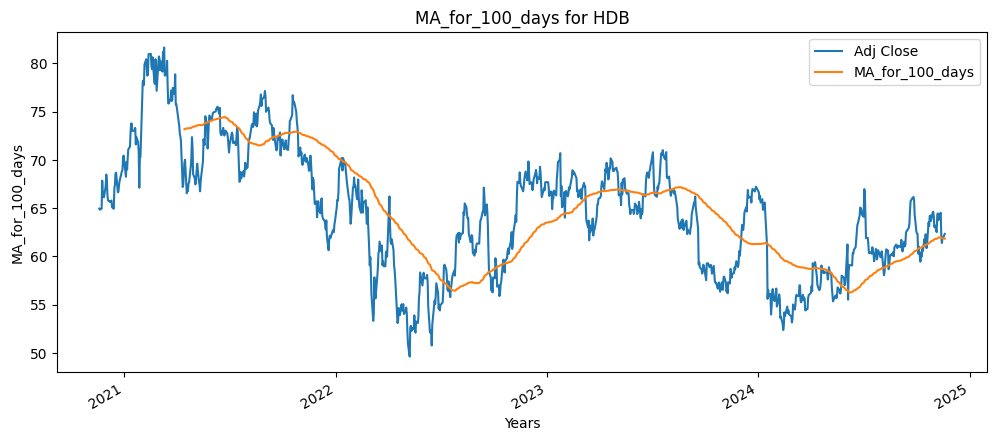

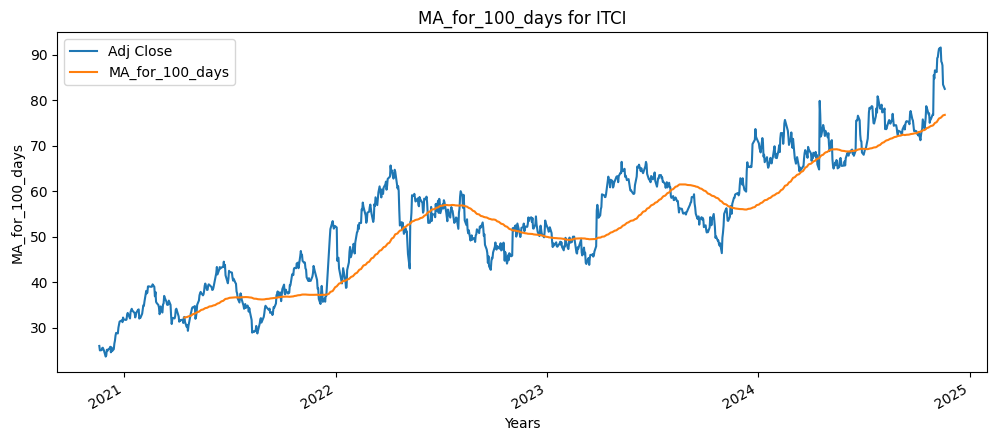

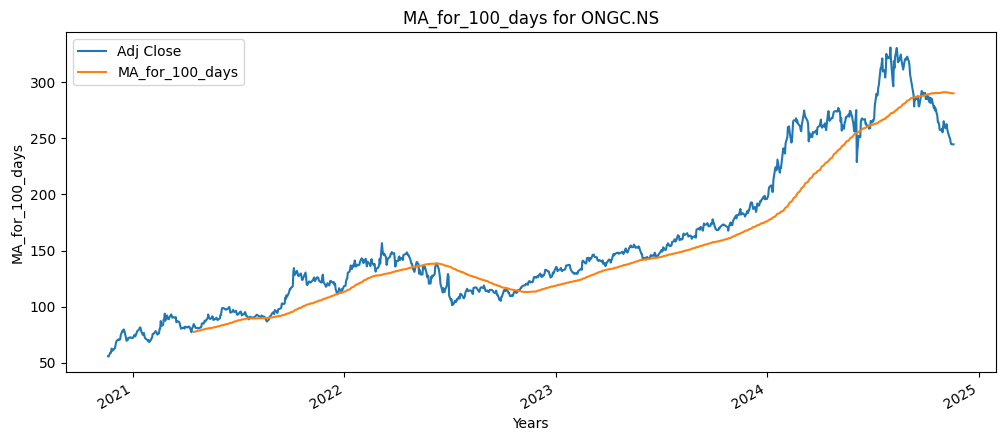

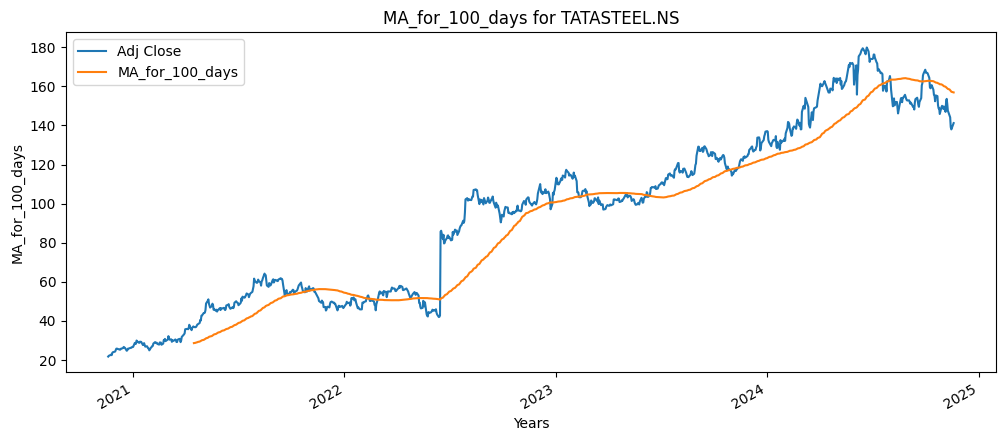

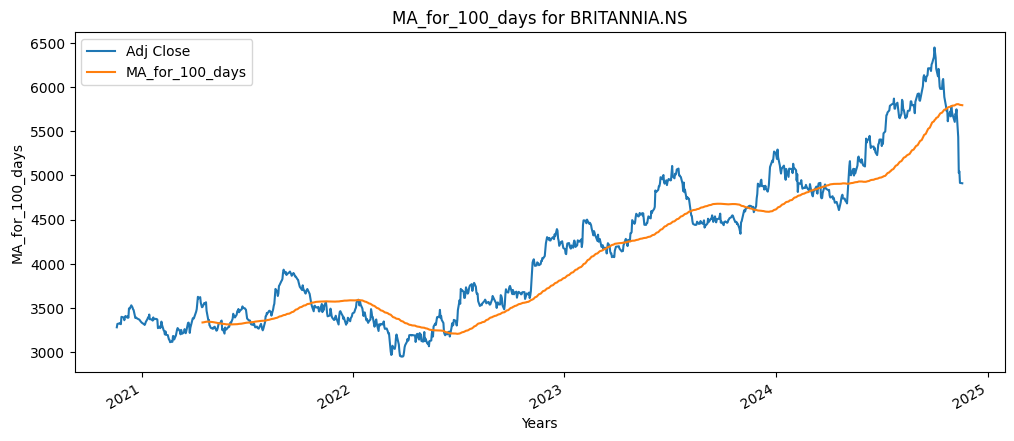

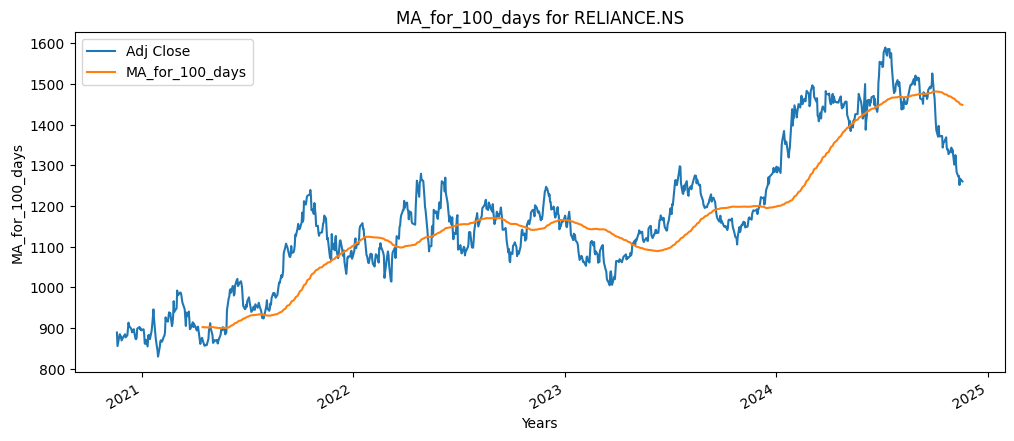

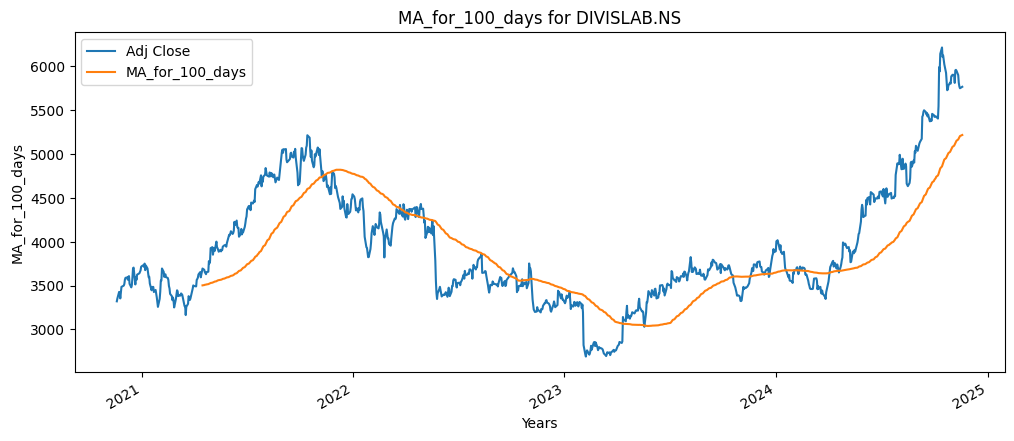

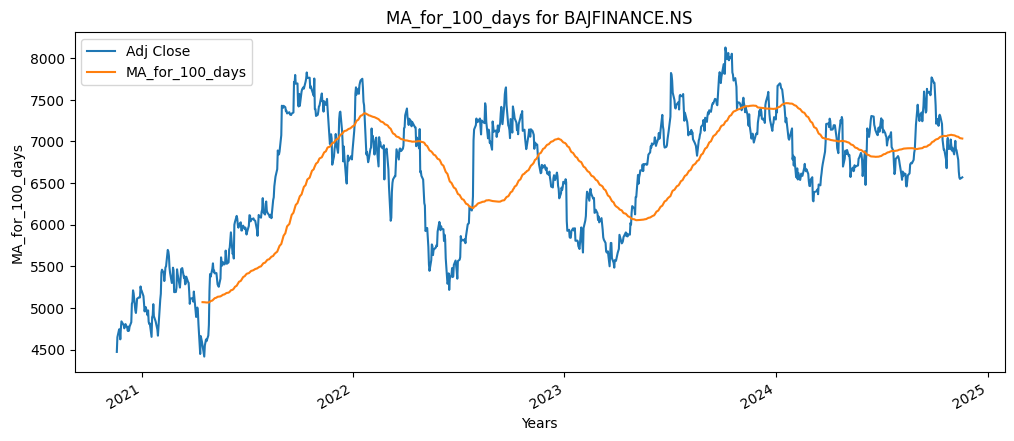

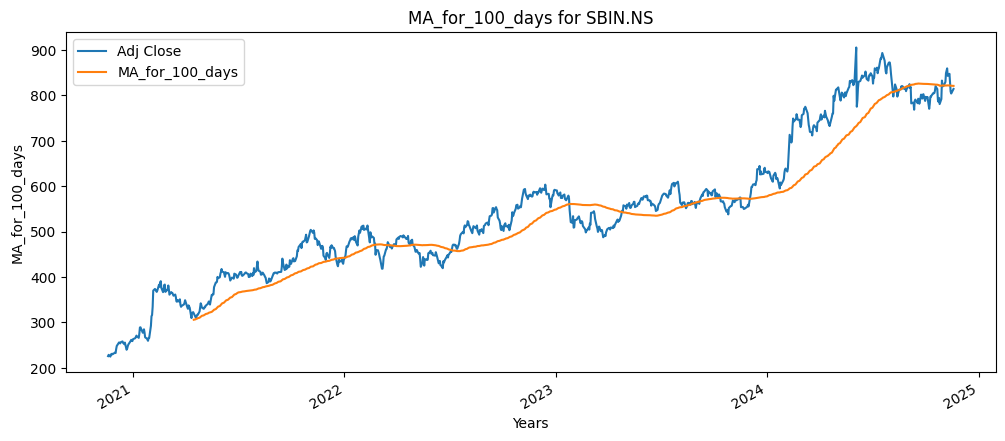

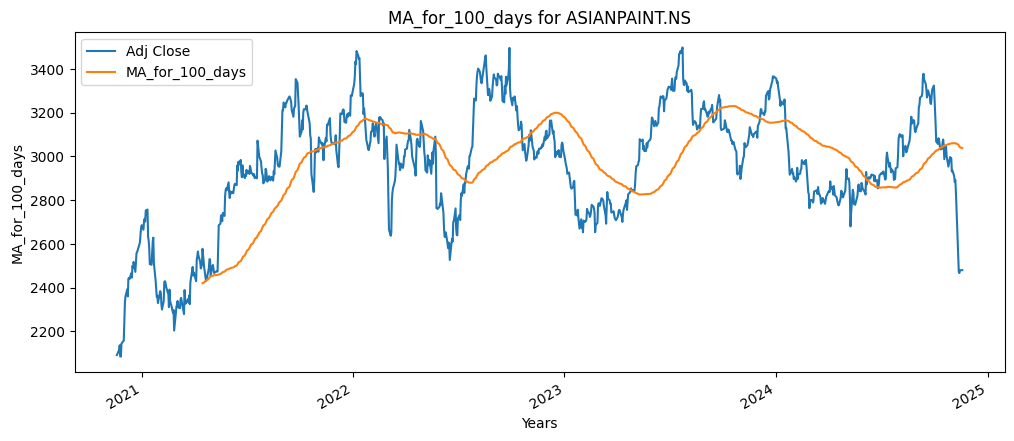

In [ ]:
for company in companies:
  data[company]['MA_for_100_days']=data[company]['Adj Close'].rolling(100).mean()
  fig, ax=plt.subplots(figsize =(12,5))
  ax.plot(data[company]['Adj Close'], label='Adj Close')
  ax.plot(data[company]['MA_for_100_days'], label='MA_for_100_days')
  ax.set_title(f'MA_for_100_days for {company}')
  ax.set_xlabel('Years')
  ax.set_ylabel('MA_for_100_days')
  ax.xaxis.set_major_locator(mdates.YearLocator())
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

  plt.gcf().autofmt_xdate()
  plt.legend()
  plt.show()

In [ ]:
for company in companies:
  data[company]['percentofchange']=data[company]['Adj Close'].pct_change()
  print(f"percentage change for {company}:")
  print(data[company][['Adj Close','percentofchange']].head())
  print("")

percentage change for HDB:
Price                      Adj Close percentofchange
Ticker                           HDB                
Date                                                
2020-11-19 00:00:00+00:00  64.953384             NaN
2020-11-20 00:00:00+00:00  64.836388       -0.001801
2020-11-23 00:00:00+00:00  64.943642        0.001654
2020-11-24 00:00:00+00:00  67.849075        0.044738
2020-11-25 00:00:00+00:00  66.503609       -0.019830

percentage change for ITCI:
Price                      Adj Close percentofchange
Ticker                          ITCI                
Date                                                
2020-11-19 00:00:00+00:00  25.980000             NaN
2020-11-20 00:00:00+00:00  25.000000       -0.037721
2020-11-23 00:00:00+00:00  25.059999        0.002400
2020-11-24 00:00:00+00:00  25.510000        0.017957
2020-11-25 00:00:00+00:00  25.590000        0.003136

percentage change for ONGC.NS:
Price                      Adj Close percentofchange
Ticker     

In [ ]:
# Splitting into train and test datasets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [ ]:
# Create training and testing datasets
def create_dataset(data, time_step=60):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
# Reshape input to be [samples, time steps, features] as expected by LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
#LSTM Model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)))  # Increased units
model.add(Dropout(0.3))  # Added dropout to prevent overfitting
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(50))
model.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=50, verbose=1)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 116ms/step - loss: 0.0780
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - loss: 0.0100
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - loss: 0.0077
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.0082
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - loss: 0.0069
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - loss: 0.0068
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - loss: 0.0076
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - loss: 0.0067
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - loss: 0.0070
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - loss: 0.0054
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - loss: 0.0049
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - loss: 0.0055
Epoch 13/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - loss: 0.0052
Epoch 14/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - loss: 0.0045
Epoch 15/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - lo

In [ ]:
# Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [ ]:
# Inverse scaling to get actual values
train_predict = scaler.inverse_transform(train_predict)
y_train_actual = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform([y_test])

In [ ]:
# Evaluation Metrics
train_mse = mean_squared_error(y_train_actual[0], train_predict[:, 0])
test_mse = mean_squared_error(y_test_actual[0], test_predict[:, 0])
print("Train MSE:", train_mse)
print("Test MSE:", test_mse)

Train MSE: 1.9414566906467068
Test MSE: 1.5148628037363647


In [ ]:
train_mape = mean_absolute_percentage_error(y_train_actual[0], train_predict[:, 0])
test_mape = mean_absolute_percentage_error(y_test_actual[0], test_predict[:, 0])
print("Train MAPE:", train_mape)
print("Test MAPE:", test_mape)

Train MAPE: 0.015915913992493647
Test MAPE: 0.01474379726311542


In [ ]:
train_r2 = r2_score(y_train_actual[0], train_predict[:, 0])
test_r2 = r2_score(y_test_actual[0], test_predict[:, 0])
print("Train R-squared:", train_r2)
print("Test R-squared:", test_r2)

Train R-squared: 0.9572655809087051
Test R-squared: 0.7855086920948092


In [ ]:
# Determine the Best Performing Company Each Year
annual_returns = pd.DataFrame()

for company, df in data.items():
    df['Year'] = df.index.year
    annual_return = df.groupby('Year')['Close'].apply(lambda x: (x.iloc[-1] / x.iloc[0] - 1) * 100)
    annual_returns[company] = annual_return

best_performers = annual_returns.idxmax(axis=1)
best_performance_values = annual_returns.max(axis=1)

best_performance_df = pd.DataFrame({
    "Year": best_performers.index,
    "Best Company": best_performers.values,
    "Annual Return (%)": best_performance_values.values
})

print("\nYear-wise Best Performing Companies:")
print(best_performance_df)



Year-wise Best Performing Companies:
   Year  Best Company  Annual Return (%)
0  2020       ONGC.NS          28.967430
1  2021  TATASTEEL.NS          72.826933
2  2022       SBIN.NS          30.352597
3  2023          ITCI          38.637249
4  2024   DIVISLAB.NS          47.262444


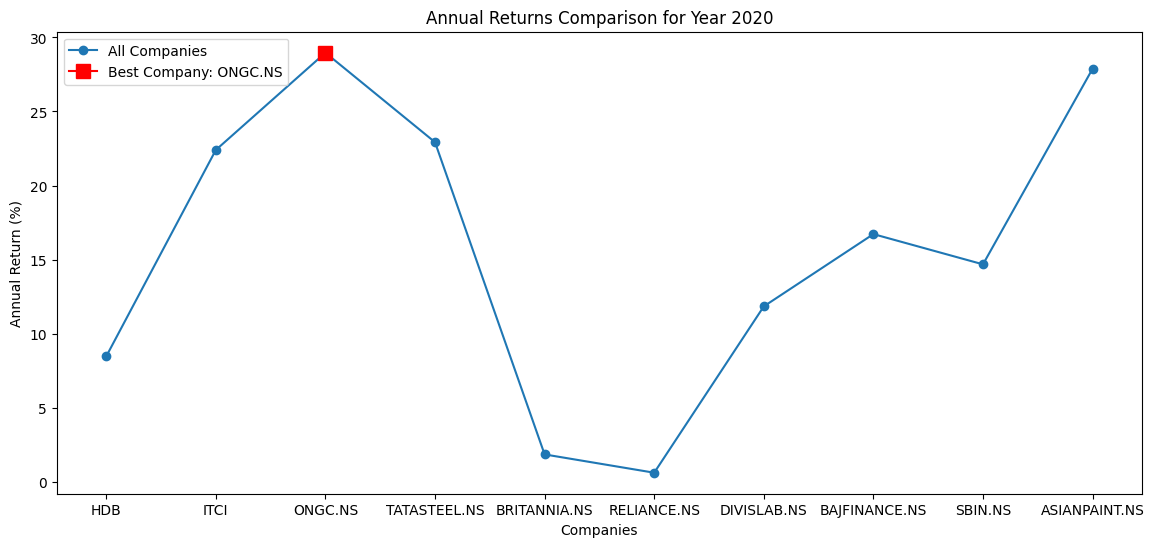

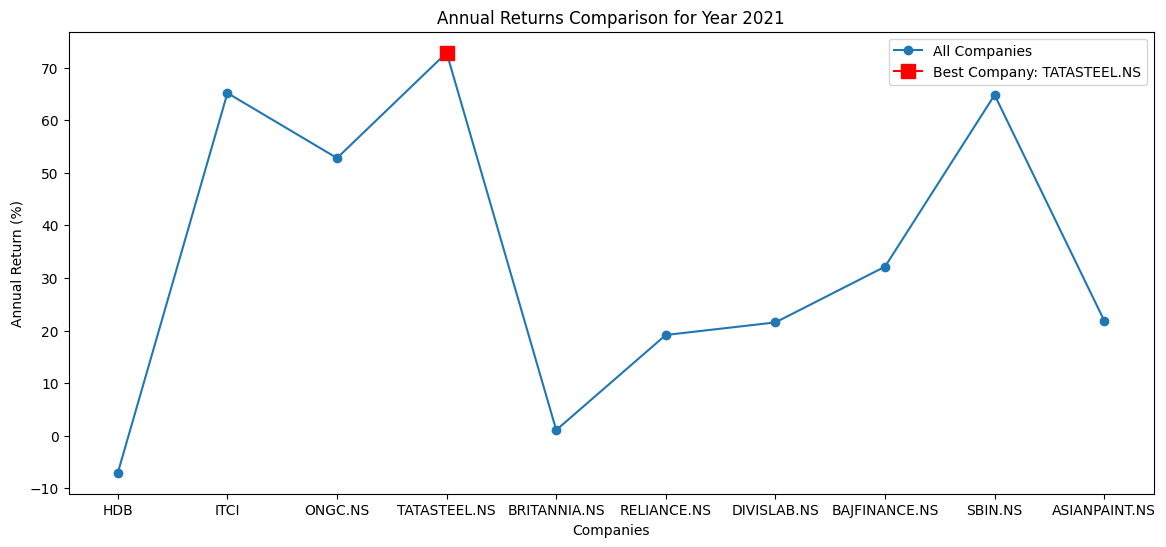

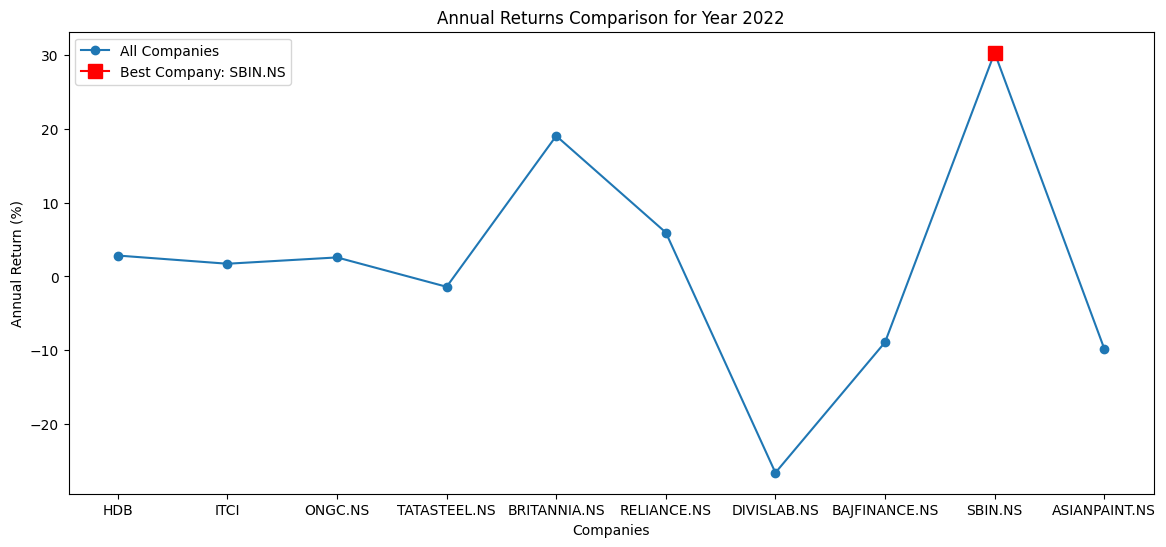

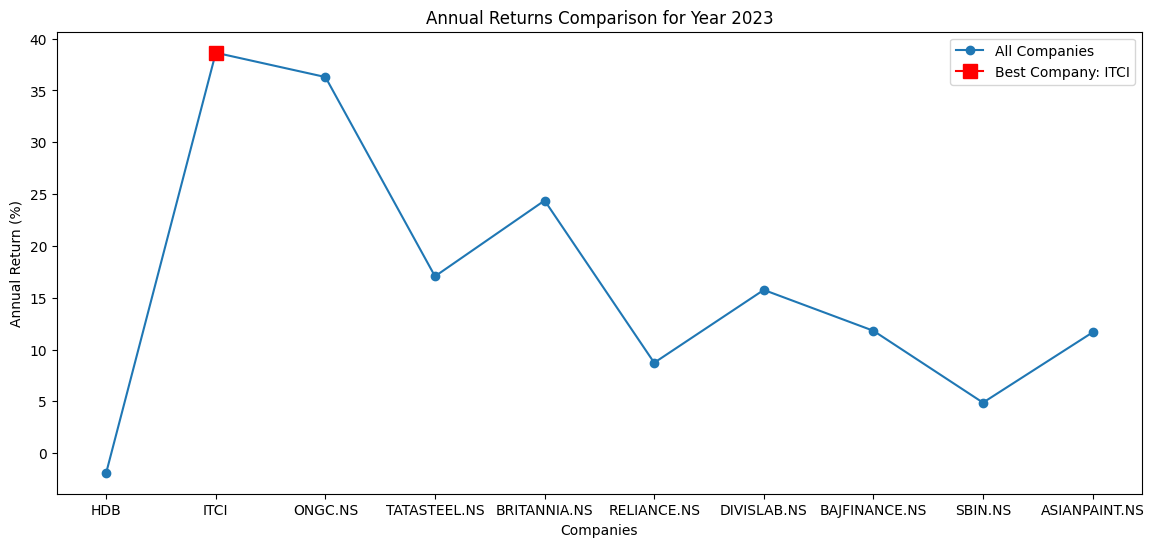

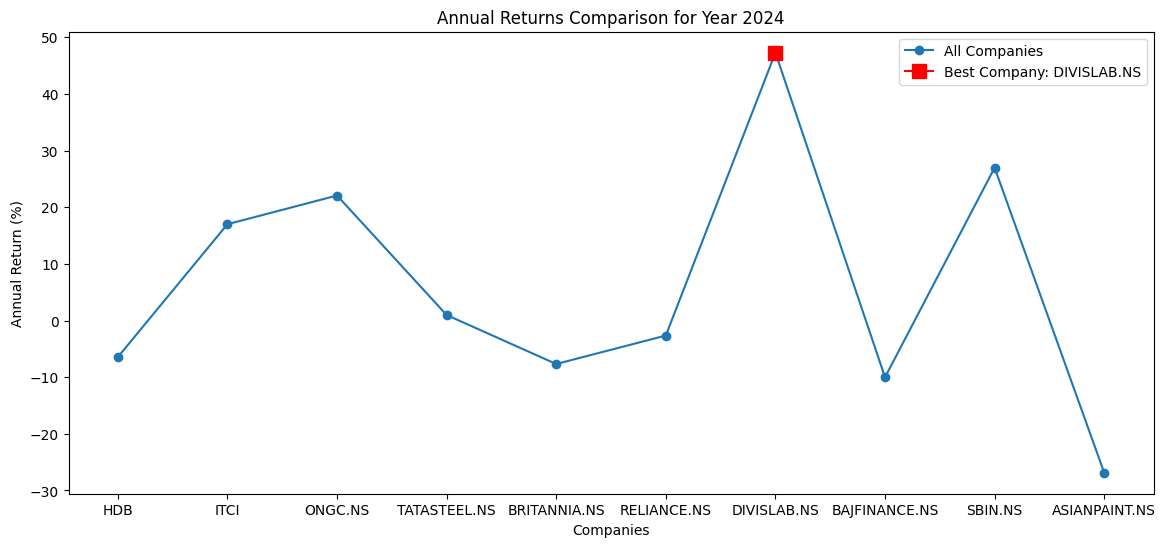

In [ ]:
# Plot Year-wise Best Performing Companies vs Others
for year in best_performance_df['Year']:
    plt.figure(figsize=(14, 6))
    plt.plot(annual_returns.loc[year], marker='o', label='All Companies')
    best_company = best_performance_df.loc[best_performance_df['Year'] == year, 'Best Company'].values[0]
    best_return = best_performance_df.loc[best_performance_df['Year'] == year, 'Annual Return (%)'].values[0]
    plt.plot(best_company, best_return, marker='s', color='red', markersize=10, label=f'Best Company: {best_company}')
    plt.title(f"Annual Returns Comparison for Year {year}")
    plt.xlabel("Companies")
    plt.ylabel("Annual Return (%)")
    plt.legend()
    plt.show()

<ipython-input-25-f5087d1b863e>:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cumulative_return = float((end_price / start_price - 1) * 100)



Overall Best Performing Company Across All Years:
Company: ONGC.NS, Cumulative Return: 247.40%


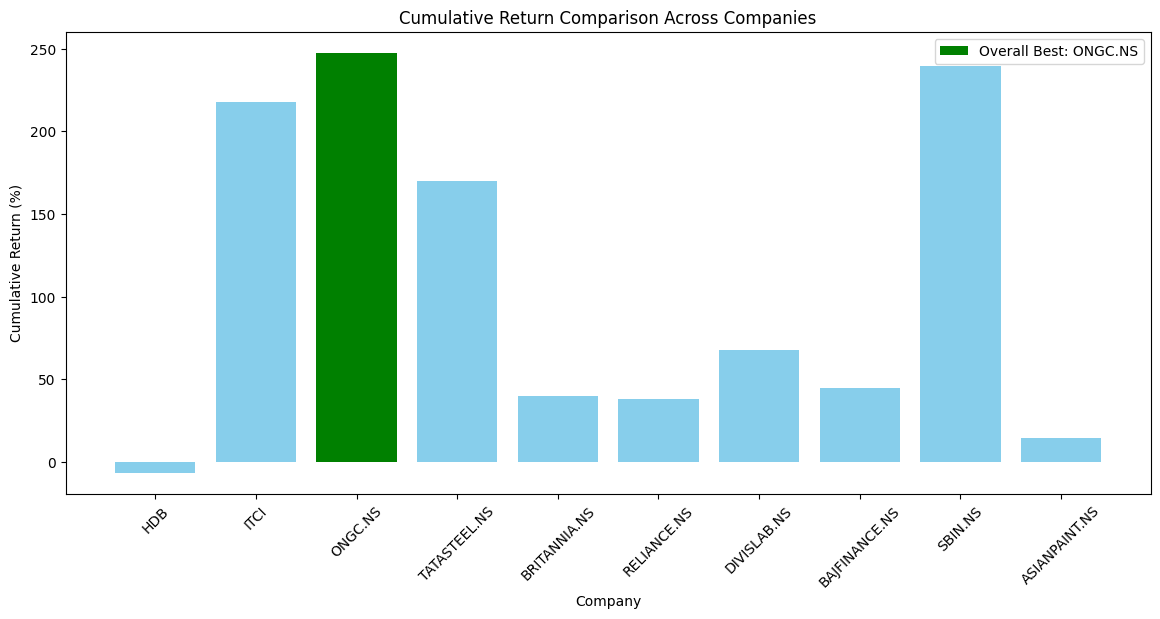

In [ ]:
# Calculate Overall Best Performing Company Across All Years
cumulative_returns = {}
for company, df in data.items():
    if len(df) > 1:
        start_price = df['Close'].iloc[0]
        end_price = df['Close'].iloc[-1]
        cumulative_return = float((end_price / start_price - 1) * 100)
        cumulative_returns[company] = cumulative_return

overall_best_company = max(cumulative_returns, key=cumulative_returns.get)
overall_best_return = cumulative_returns[overall_best_company]

print("\nOverall Best Performing Company Across All Years:")
print(f"Company: {overall_best_company}, Cumulative Return: {overall_best_return:.2f}%")

# Plot Overall Cumulative Returns for Each Company
plt.figure(figsize=(14, 6))
plt.bar(cumulative_returns.keys(), cumulative_returns.values(), color='skyblue')
plt.bar(overall_best_company, overall_best_return, color='green', label=f'Overall Best: {overall_best_company}')
plt.xlabel("Company")
plt.ylabel("Cumulative Return (%)")
plt.title("Cumulative Return Comparison Across Companies")
plt.legend()
plt.xticks(rotation=45)
plt.show()